# Cut Implementations

By default I was using the error function, but I stumbled across some other implementations. This chapter explores some of the options.

Note: This will write out a file called `jax_cuts.py` which contains the source code so that the code can be tested in other places.

In [1]:
from util_nb import run_and_save

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp

from jax_helpers import data_sig_j, data_back_j
from typing import Callable
import functools as ft

## Error Function

This was where I started. Lets develop a few tools here we can use later on to define the error function.

In [3]:
def cut_erf(cut: float, data):
    "Take a jax array and calculate an error function on it"
    return (jax.lax.erf(data - cut) + 1) / 2.0


def sig_sqrt_b(f, sig_j, back_j):
    "Calculate the S/sqrt(B) for two 1D numpy arrays with the cut at cut."

    # Weight the data and then do the sum
    wts_sig = f(sig_j)
    wts_back = f(back_j)

    S = jnp.sum(wts_sig)
    B = jnp.sum(wts_back)

    return S / jnp.sqrt(B)

Setup some setup to plot the function and its grad - that we can re-use below.

Start with the function itself - or its average weight.

In [4]:
data_max = max(max(data_sig_j), max(data_back_j))
data_min = min(min(data_sig_j), min(data_back_j))
lower_limit = data_min - (abs(data_min) * 0.2)
upper_limit = data_max + (abs(data_max) * 0.2)

In [5]:
x_values = np.linspace(lower_limit, upper_limit, 100)

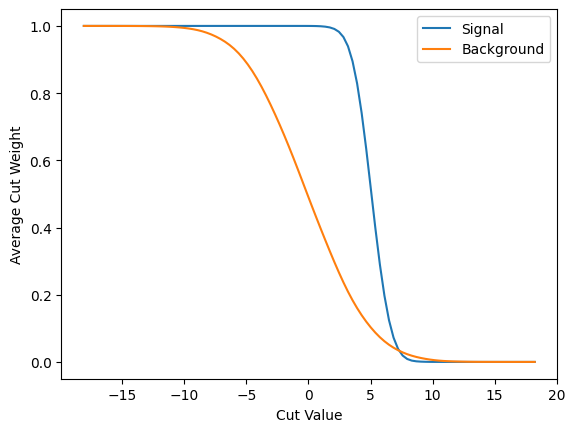

In [6]:
def plot_avg_weight(f: Callable):
    plt.plot(x_values, np.array([jnp.average(f(c, data_sig_j)) for c in x_values]), label='Signal')
    plt.plot(x_values, np.array([jnp.average(f(c, data_back_j)) for c in x_values]), label='Background')
    plt.xlabel('Cut Value')
    plt.ylabel('Average Cut Weight')
    plt.legend()
    plt.show()

plot_avg_weight(cut_erf)

Next lets look at the $S/\sqrt{B}$ background.

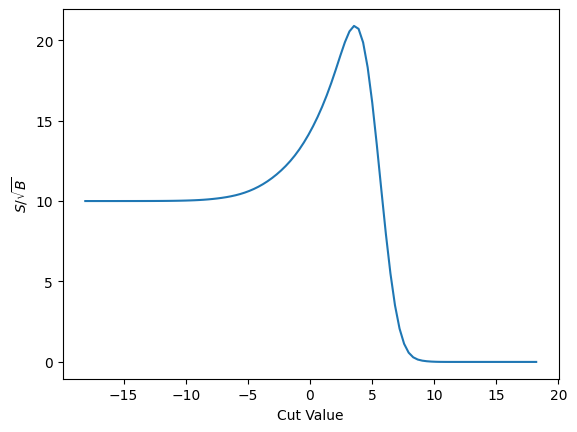

In [7]:
def plot_s_sqrt_b(f):
    plt.plot(x_values, np.array([sig_sqrt_b(ft.partial(f, c), data_sig_j, data_back_j) for c in x_values]))
    plt.xlabel('Cut Value')
    plt.ylabel(r'$S/\sqrt{B}$')

plot_s_sqrt_b(cut_erf)

And finally the gradient of that